In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
V0 = 1.0  # Delta potential strength
mass = 1.0
hbar = (1/5)**0.5
E = 2.0
k = np.sqrt(2 * mass * E) / hbar  # Wave number

# Single channel (no j indices)
n_ch = 1

# Spatial grids
x = np.linspace(-60, 60, 800)
x_prime = np.linspace(-60, 60, 800)
dx = x[1] - x[0]

print(f"Wave number k: {k:.6f}")
print(f"Energy E: {E}")
print(f"Delta potential strength V0: {V0}")

Wave number k: 4.472136
Energy E: 2.0
Delta potential strength V0: 1.0


In [2]:
# Initial wavefunction (incident wave from left)
psi = np.zeros((1, len(x)), dtype=np.complex128)
psi[0, :] = np.exp(1j * k * x)

print(f"Initial incident wave established")
print(f"Wave amplitude at x=0: {psi[0, len(x)//2]:.6f}")


Initial incident wave established
Wave amplitude at x=0: 0.944137+0.329553j


In [3]:
def compute_delta_potential(x_p):
    """Compute delta function potential at x_p"""
    # Delta function approximated as narrow Gaussian
    sigma = dx  # Width of delta approximation
    return (V0 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x_p**2 / (2 * sigma**2))

# Precompute potential for all x_prime points
potential_vals = np.array([compute_delta_potential(xp) for xp in x_prime])
print(f"Delta potential computed for {len(x_prime)} grid points")
print(f"Peak potential value: {np.max(potential_vals):.6f}")


Delta potential computed for 800 grid points
Peak potential value: 2.344168


In [4]:
def next_order_iteration_delta(psi_prev, f_current, k_val, energy):
    """
    Lippmann-Schwinger iteration for delta function potential
    Returns updated wavefunction and f coefficients [reflection, transmission]
    """
    psi_next = np.zeros_like(psi_prev)
    
    # Storage for f coefficients: [reflection, transmission]
    f_coeffs = np.zeros(2, dtype=np.complex128)
    
    # Incident wave
    phi_inc = np.exp(1j * k_val * x)
    
    #delta function potential 
    potential_vals = np.array([compute_delta_potential(xp) for xp in x_prime])
    
    # Initialize scattered wave components
    scattered_neg = np.zeros_like(x, dtype=np.complex128)  # x < 0 region
    scattered_pos = np.zeros_like(x, dtype=np.complex128)  # x >= 0 region
    
    # Loop over regions: -1 for x < 0 (reflection), +1 for x >= 0 (transmission)
    for sgn_idx, sgn_x in enumerate([-1, +1]):
        
        # Current wavefunction interpolated on x_prime grid
        psi_coupling = np.interp(x_prime, x, psi_prev[0])
        
        # Phase factor with sgn(x)
        phase_factor = np.exp(-1j * k_val * x_prime * sgn_x)
        
        # Complete integrand
        integrand = phase_factor * potential_vals * psi_coupling
        
        # Numerical integration over x_prime
        total_integral = np.trapz(integrand, x_prime)
        
        # Apply prefactor to get f coefficient
        prefactor = -1j * mass / (hbar**2 * k_val)
        f_coefficient = prefactor * total_integral
        
        # Store f coefficients
        f_coeffs[sgn_idx] = f_coefficient
        
        if sgn_x == -1:  # Reflection (x < 0)
            mask_neg = x < 0
            x_neg = x[mask_neg]
            outgoing_wave_neg = np.exp(-1j * k_val * x_neg)  # e^(-ikx) for x<0
            scattered_neg[mask_neg] = f_coefficient * outgoing_wave_neg
            
        else:  # Transmission (x >= 0)
            mask_pos = x >= 0
            x_pos = x[mask_pos]
            outgoing_wave_pos = np.exp(1j * k_val * x_pos)  # e^(ikx) for x>0 
            scattered_pos[mask_pos] = f_coefficient * outgoing_wave_pos
    
    # Combine scattered waves
    scattered_total = scattered_neg + scattered_pos
    
    # Total wavefunction = incident + scattered
    psi_next[0, :] = phi_inc + scattered_total
    
    return psi_next, f_coeffs


In [5]:
# Run iterative solution
order_max = 100
psi_orders = [psi.copy()]
f_orders = []

# Initialize f coefficients for 0th order (no scattering)
f_initial = np.zeros(2, dtype=np.complex128)
f_orders.append(f_initial)

print("Computing Lippmann-Schwinger iterations for delta potential...")
for order in range(1, order_max + 1):
    print(f"Order {order}...")
    psi_new, f_new = next_order_iteration_delta(psi_orders[-1], f_orders[-1], k, E)
    psi_orders.append(psi_new)
    f_orders.append(f_new)

print(f"Computation completed up to order {order_max}")


Computing Lippmann-Schwinger iterations for delta potential...
Order 1...
Order 2...
Order 3...
Order 4...
Order 5...
Order 6...
Order 7...
Order 8...
Order 9...
Order 10...
Order 11...
Order 12...
Order 13...
Order 14...
Order 15...
Order 16...
Order 17...
Order 18...
Order 19...
Order 20...
Order 21...
Order 22...
Order 23...
Order 24...
Order 25...
Order 26...
Order 27...
Order 28...
Order 29...
Order 30...
Order 31...
Order 32...
Order 33...
Order 34...
Order 35...
Order 36...
Order 37...
Order 38...
Order 39...
Order 40...
Order 41...
Order 42...
Order 43...
Order 44...
Order 45...
Order 46...
Order 47...
Order 48...
Order 49...
Order 50...
Order 51...
Order 52...
Order 53...
Order 54...
Order 55...
Order 56...
Order 57...
Order 58...
Order 59...
Order 60...
Order 61...
Order 62...
Order 63...
Order 64...
Order 65...
Order 66...
Order 67...
Order 68...
Order 69...
Order 70...
Order 71...
Order 72...
Order 73...
Order 74...
Order 75...
Order 76...
Order 77...
Order 78...
Order 79..

In [6]:
def analytical_transmission_reflection(k_val, V0_val, mass_val, hbar_val):
    """
    Analytical transmission and reflection coefficients for delta potential
    """
    # Transmission coefficient
    denominator = k_val + 1j * mass_val * V0_val / hbar_val**2
    t_analytic = k_val / denominator
    
    # Reflection coefficient  
    r_analytic = (-1j * mass_val * V0_val / hbar_val**2) / denominator
    
    return t_analytic, r_analytic

def transmission_vs_k(k_range, V0_val, mass_val, hbar_val):
    """
    Compute transmission coefficient |t|^2 as function of k
    """
    T_analytic = np.zeros_like(k_range)
    
    for i, k_val in enumerate(k_range):
        t_val, _ = analytical_transmission_reflection(k_val, V0_val, mass_val, hbar_val)
        T_analytic[i] = np.abs(t_val)**2
    
    return T_analytic

# Compute analytical values for current parameters
t_exact, r_exact = analytical_transmission_reflection(k, V0, mass, hbar)
print(f"Analytical transmission coefficient: {t_exact:.6f}")
print(f"Analytical reflection coefficient: {r_exact:.6f}")
print(f"Analytical |t|^2 + |r|^2 = {np.abs(t_exact)**2 + np.abs(r_exact)**2:.6f}")


Analytical transmission coefficient: 0.444444-0.496904j
Analytical reflection coefficient: -0.555556-0.496904j
Analytical |t|^2 + |r|^2 = 1.000000


In [7]:
# Results display
print("\n" + "="*70)
print("DELTA FUNCTION POTENTIAL SCATTERING RESULTS")
print("="*70)

print(f"\nAnalytical Results:")
print(f"Transmission |t|^2 = {np.abs(t_exact)**2:.6f}")
print(f"Reflection   |r|^2 = {np.abs(r_exact)**2:.6f}")
print(f"Total probability  = {np.abs(t_exact)**2 + np.abs(r_exact)**2:.6f}")

print(f"\nNumerical Results by Order:")
print("-" * 40)

for order in range(min(10, order_max + 1)):
    f_vals = f_orders[order]
    T_numerical = np.abs(f_vals[1])**2
    R_numerical = np.abs(f_vals[0])**2
    
    print(f"Order {order:2d}: T = {T_numerical:.6f}, R = {R_numerical:.6f}, "
          f"Total = {T_numerical + R_numerical:.6f}")

# Final comparison
final_order = order_max
f_final = f_orders[final_order]
print(f"\nFinal Numerical vs Analytical Comparison (Order {final_order}):")
print(f"Transmission: Numerical = {np.abs(f_final[1])**2:.6f}, "
      f"Analytical = {np.abs(t_exact)**2:.6f}")
print(f"Reflection:   Numerical = {np.abs(f_final[0])**2:.6f}, "
      f"Analytical = {np.abs(r_exact)**2:.6f}")



DELTA FUNCTION POTENTIAL SCATTERING RESULTS

Analytical Results:
Transmission |t|^2 = 0.444444
Reflection   |r|^2 = 0.555556
Total probability  = 1.000000

Numerical Results by Order:
----------------------------------------
Order  0: T = 0.000000, R = 0.000000, Total = 0.000000
Order  1: T = 1.250000, R = 0.205689, Total = 1.455689
Order  2: T = 2.183731, R = 1.010130, Total = 3.193861
Order  3: T = 2.060039, R = 1.326817, Total = 3.386855
Order  4: T = 1.215446, R = 0.787014, Total = 2.002459
Order  5: T = 0.434094, R = 0.214992, Total = 0.649086
Order  6: T = 0.544890, R = 0.090386, Total = 0.635276
Order  7: T = 1.159102, R = 0.392910, Total = 1.552012
Order  8: T = 1.499085, R = 0.690796, Total = 2.189881
Order  9: T = 1.273752, R = 0.656540, Total = 1.930292

Final Numerical vs Analytical Comparison (Order 100):
Transmission: Numerical = 0.955685, Analytical = 0.444444
Reflection:   Numerical = 0.373529, Analytical = 0.555556


In [8]:
def plot_order_results(order):
    """Plot results for a specific order"""
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Real parts
    plt.subplot(1, 3, 1)
    plt.plot(x, psi_orders[order][0].real, 'b-', linewidth=2, label='Real ψ(x)')
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Delta potential')
    
    plt.title(f'Real Part - Order {order}')
    plt.xlabel('x')
    plt.ylabel('Re(ψ(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Imaginary parts
    plt.subplot(1, 3, 2)
    plt.plot(x, psi_orders[order][0].imag, 'g-', linewidth=2, label='Imag ψ(x)')
    plt.axvline(x=0, color='r', linestyle='--', alpha=0.7, label='Delta potential')
    
    plt.title(f'Imaginary Part - Order {order}')
    plt.xlabel('x')
    plt.ylabel('Im(ψ(x))')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: f coefficients magnitude
    plt.subplot(1, 3, 3)
    f_vals = f_orders[order]
    coeffs = ['Reflection', 'Transmission']
    magnitudes = [np.abs(f_vals[0]), np.abs(f_vals[1])]
    
    bars = plt.bar(coeffs, magnitudes, alpha=0.7, color=['red', 'blue'])
    
    # Add analytical comparison
    if order > 0:
        analytical_mags = [np.abs(r_exact), np.abs(t_exact)]
        plt.bar(coeffs, analytical_mags, alpha=0.3, color=['darkred', 'darkblue'], 
                label='Analytical')
    
    plt.title(f'|f coefficients| - Order {order}')
    plt.ylabel('|f|')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add values on bars
    for i, (bar, val) in enumerate(zip(bars, magnitudes)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


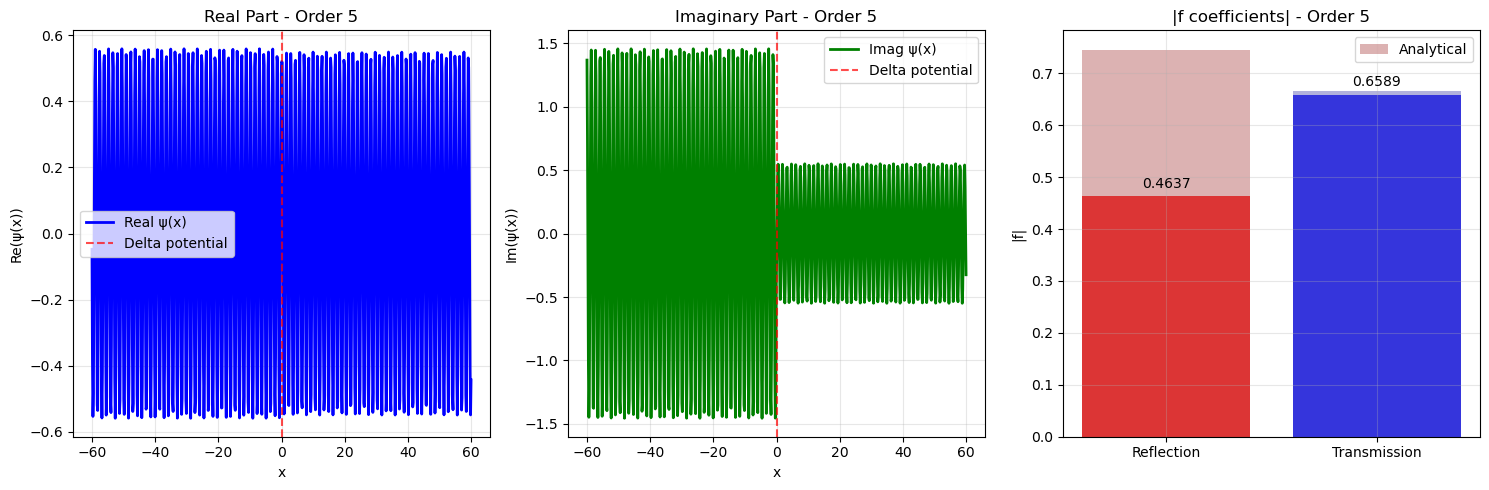

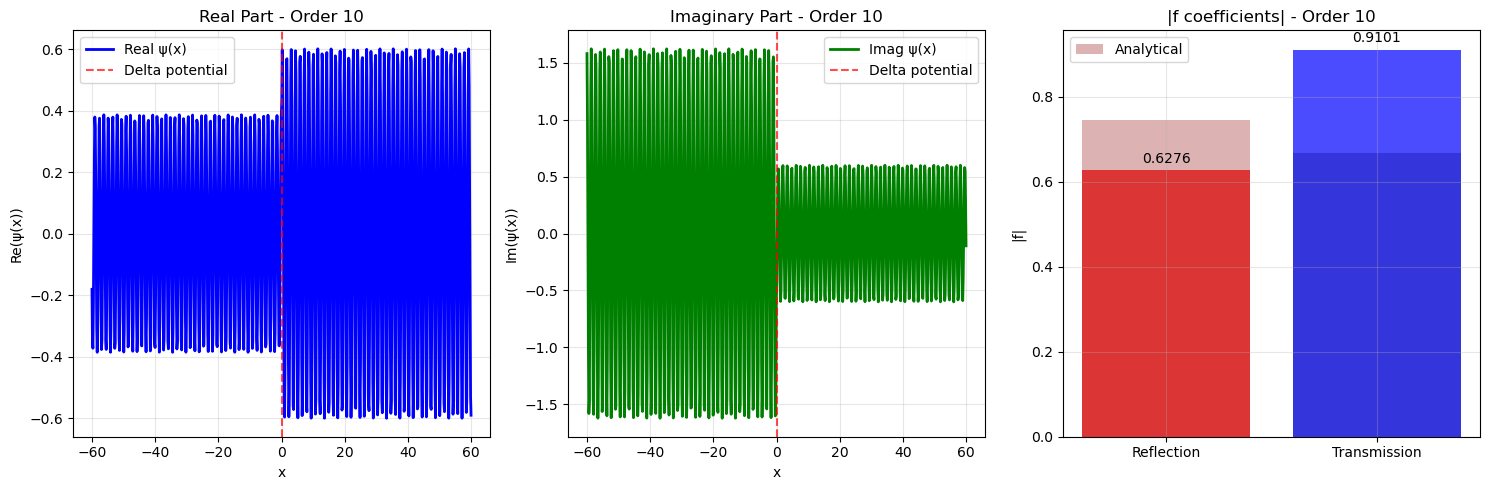

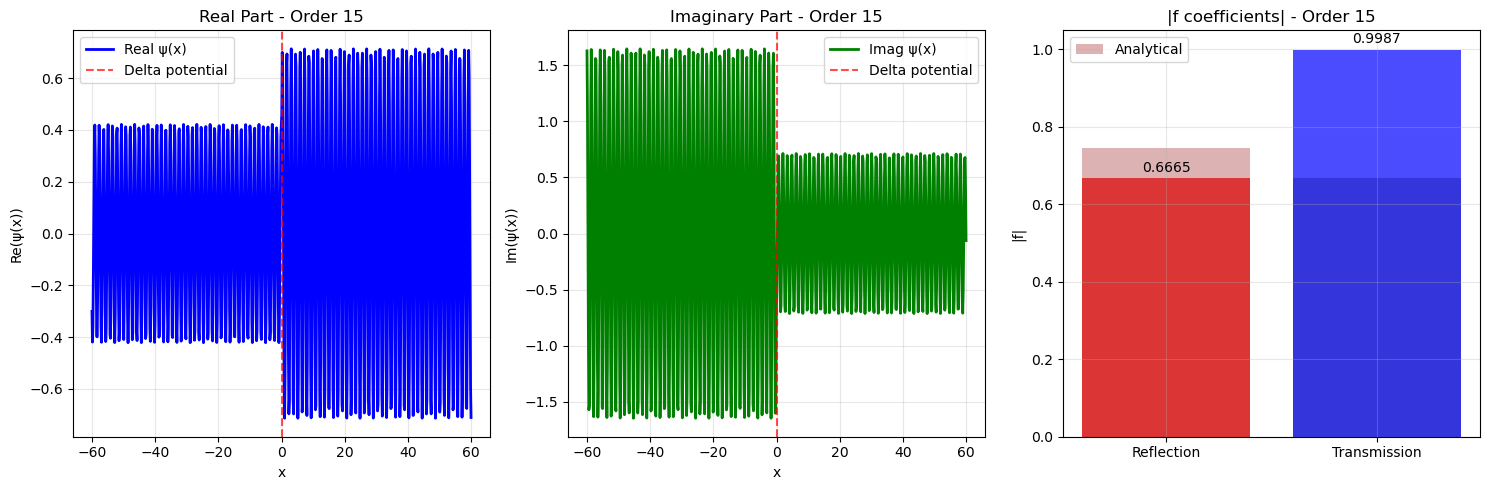

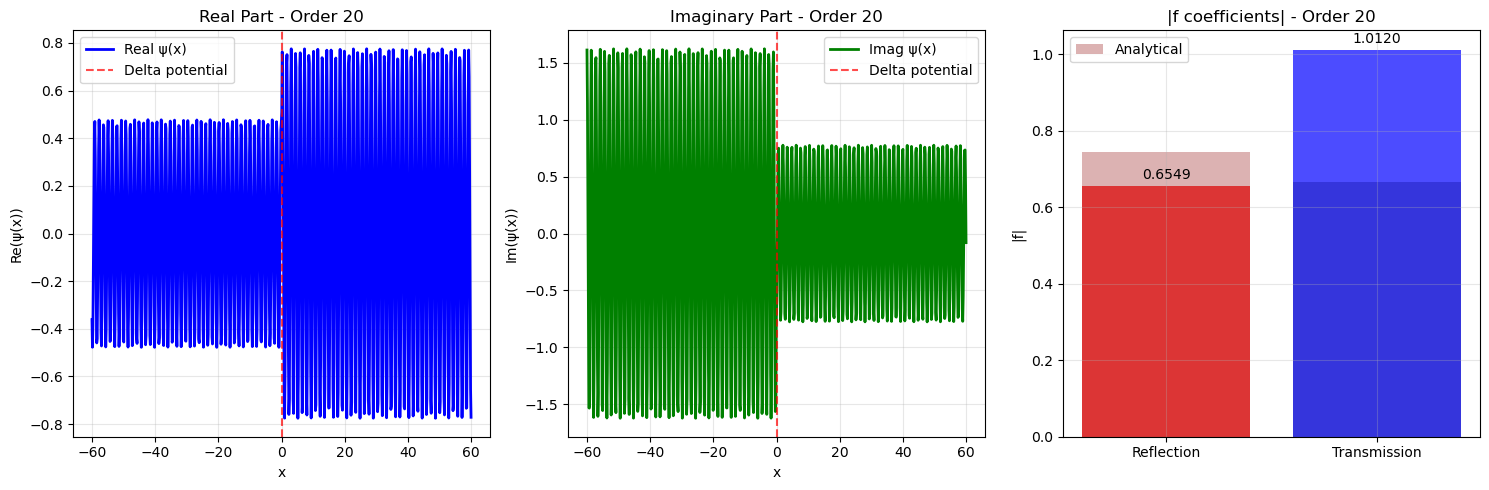

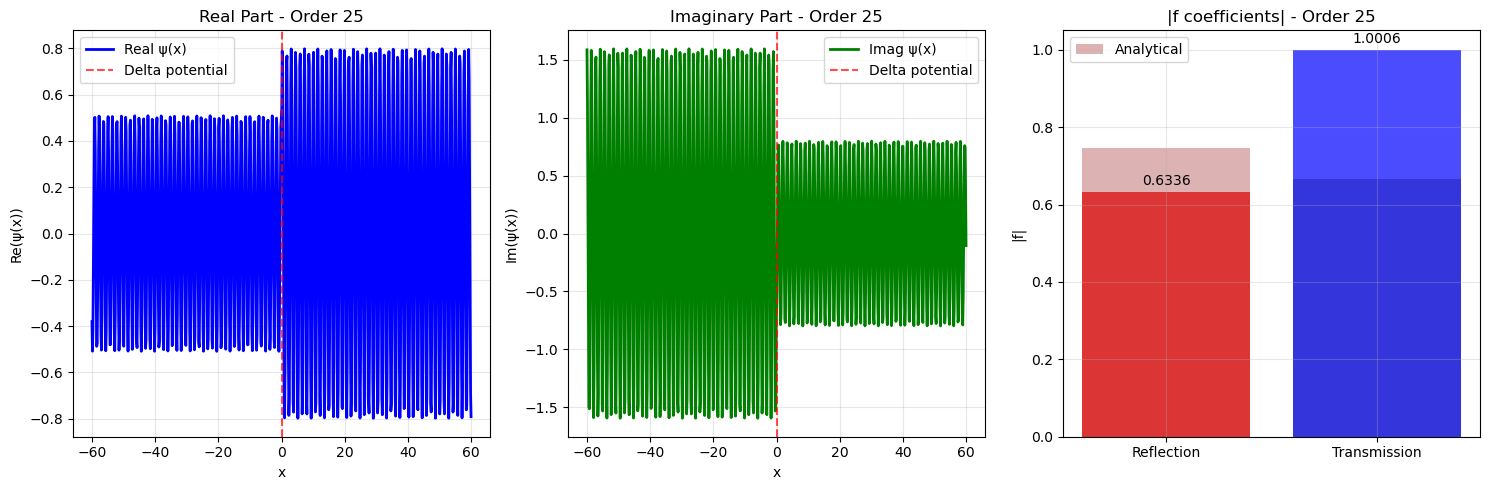

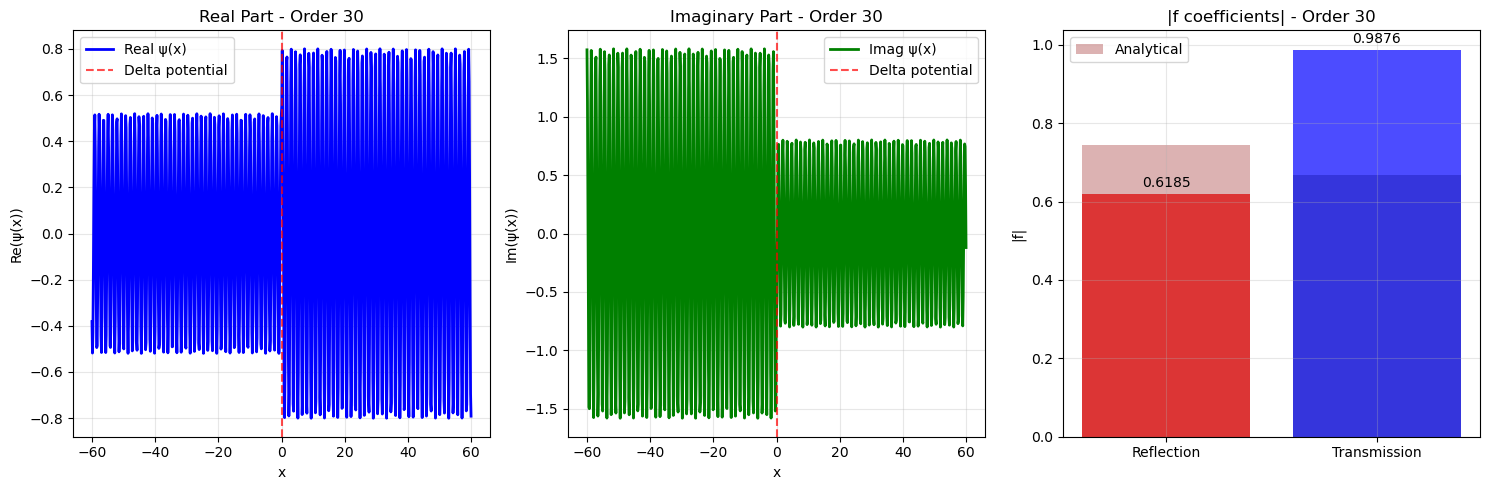

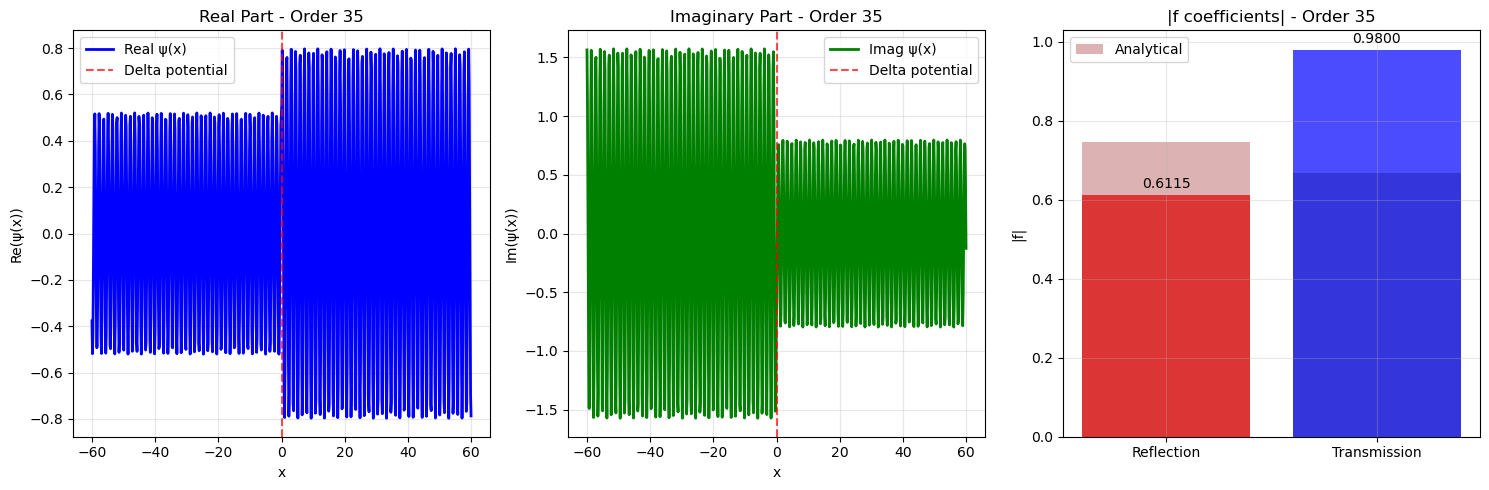

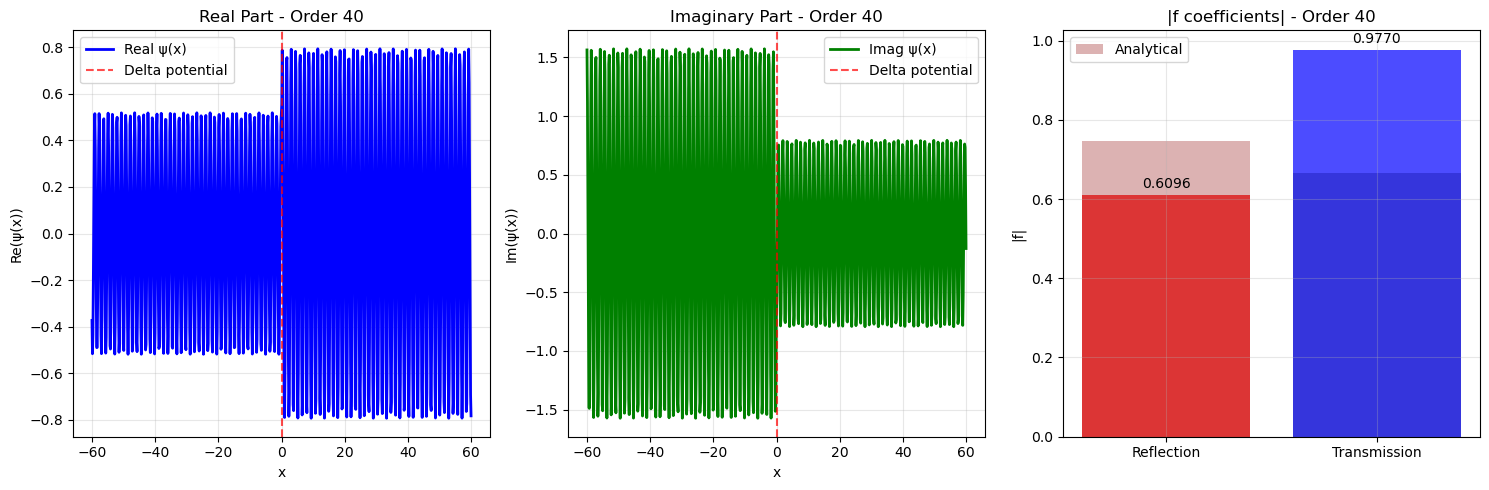

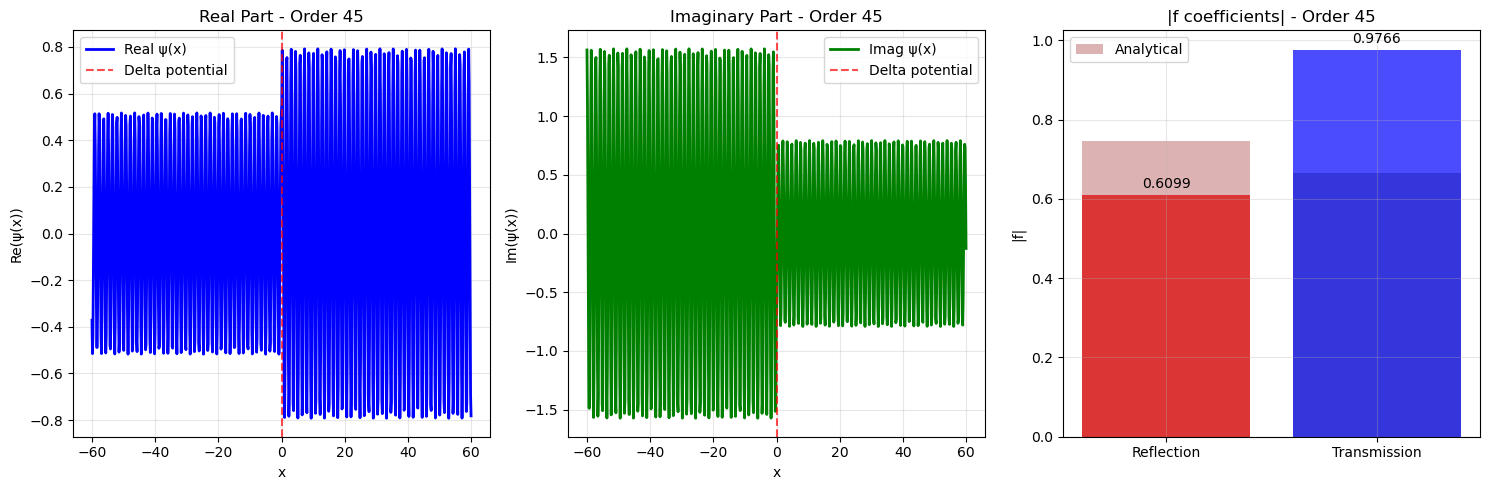

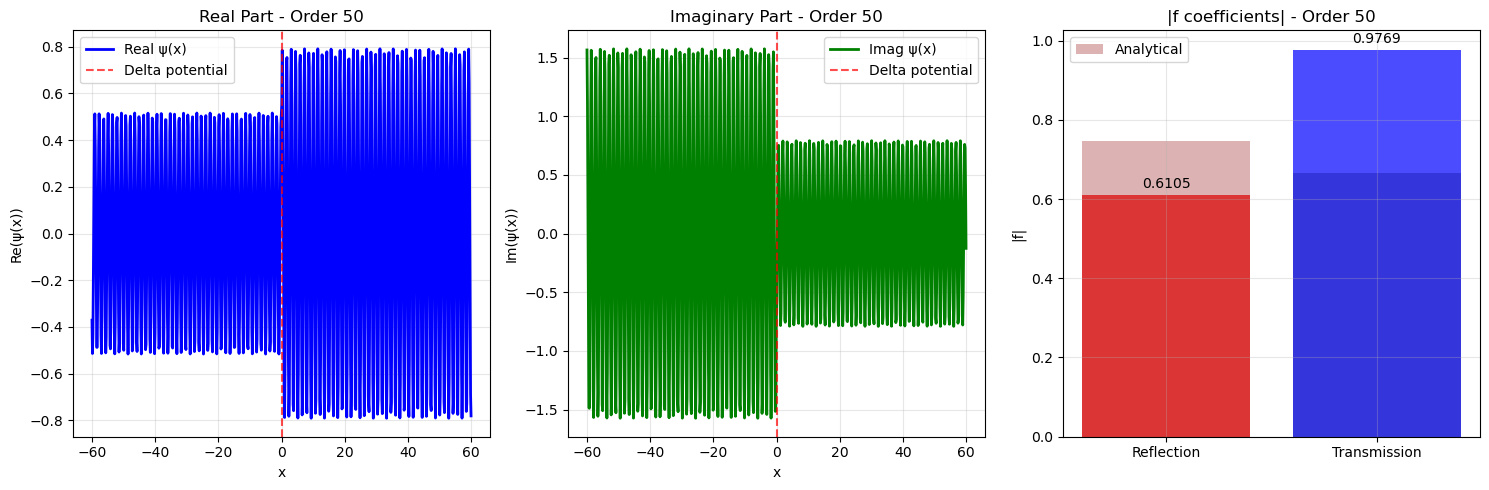

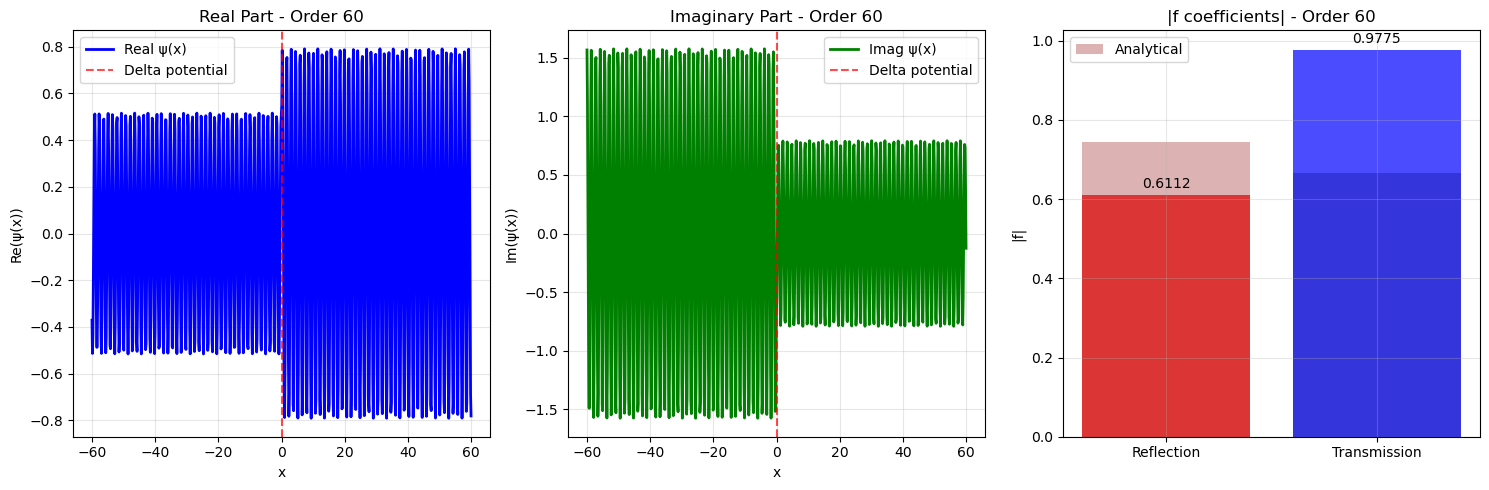

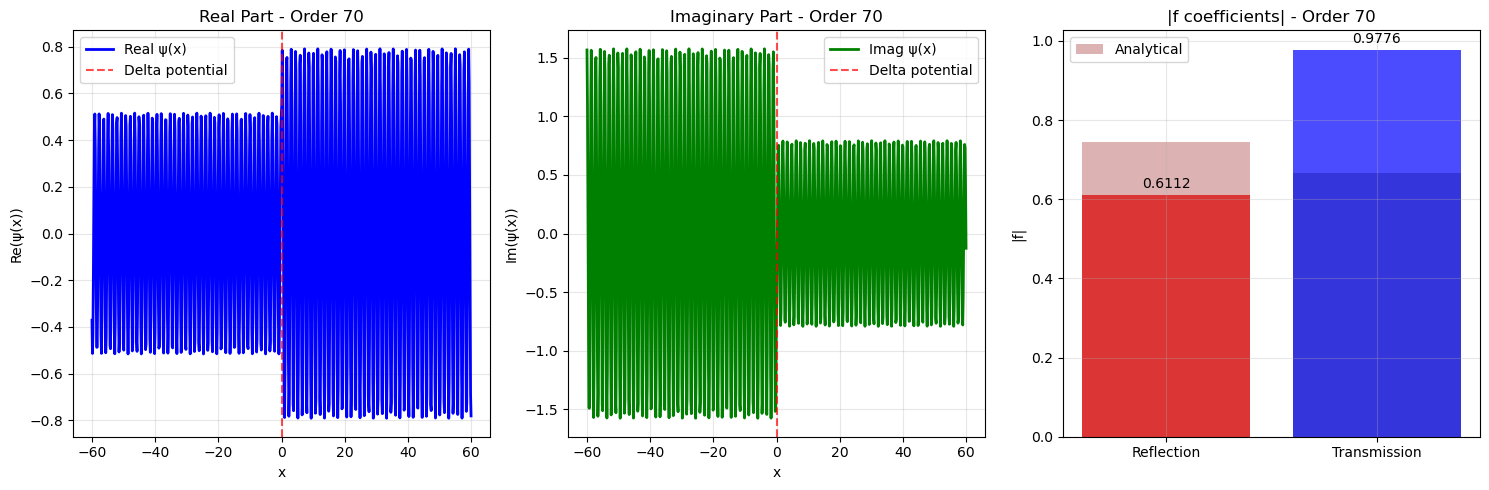

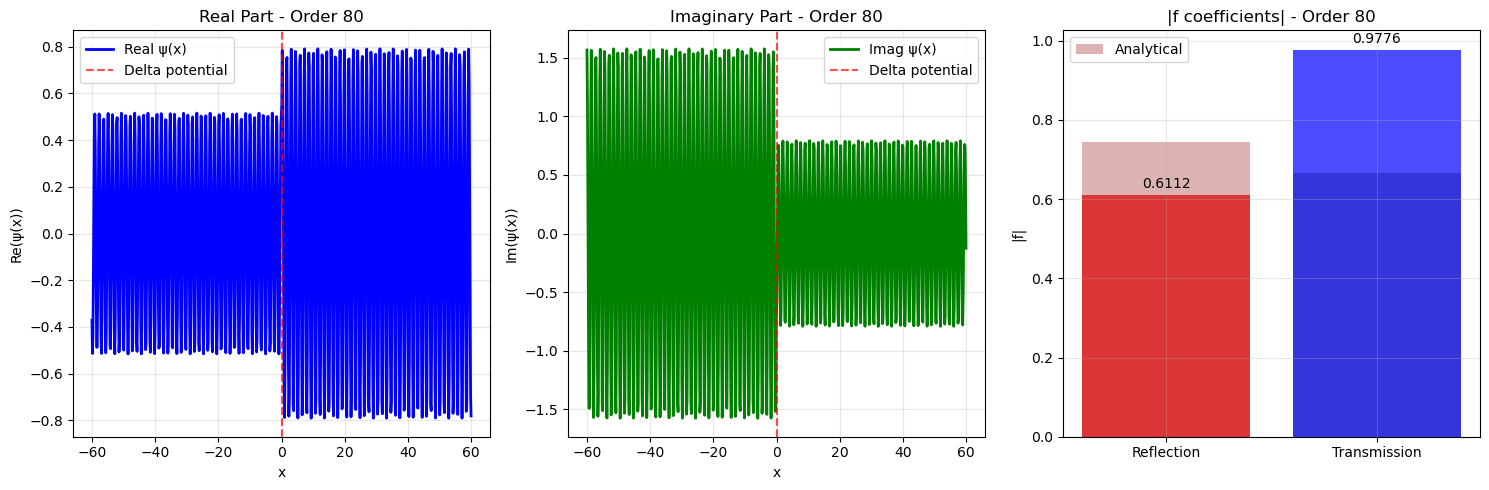

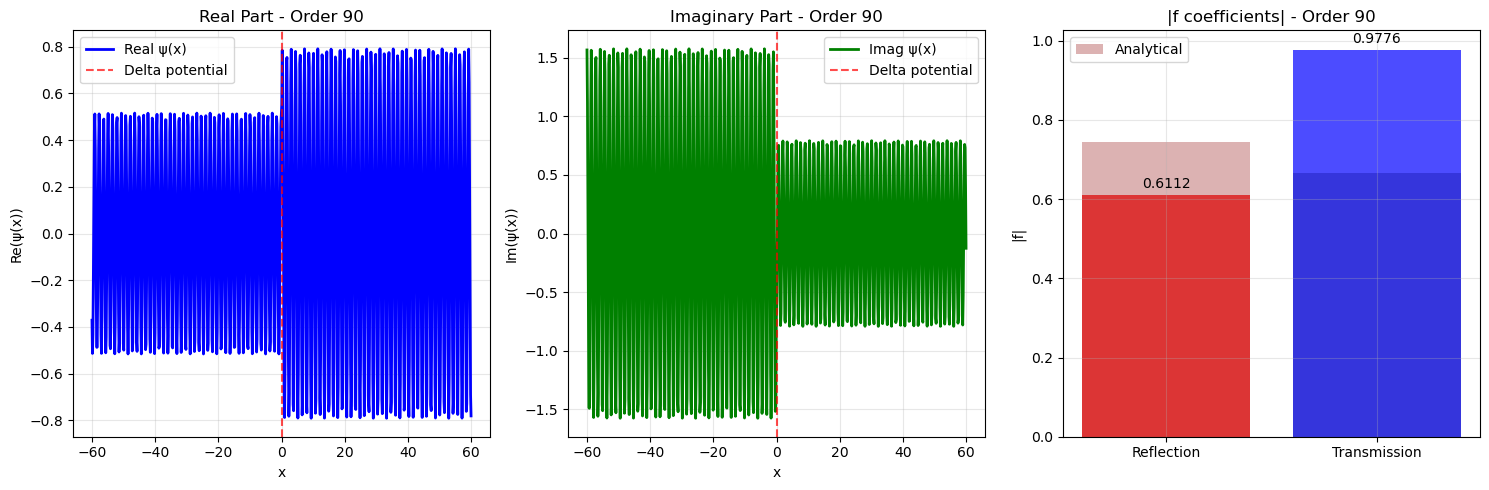

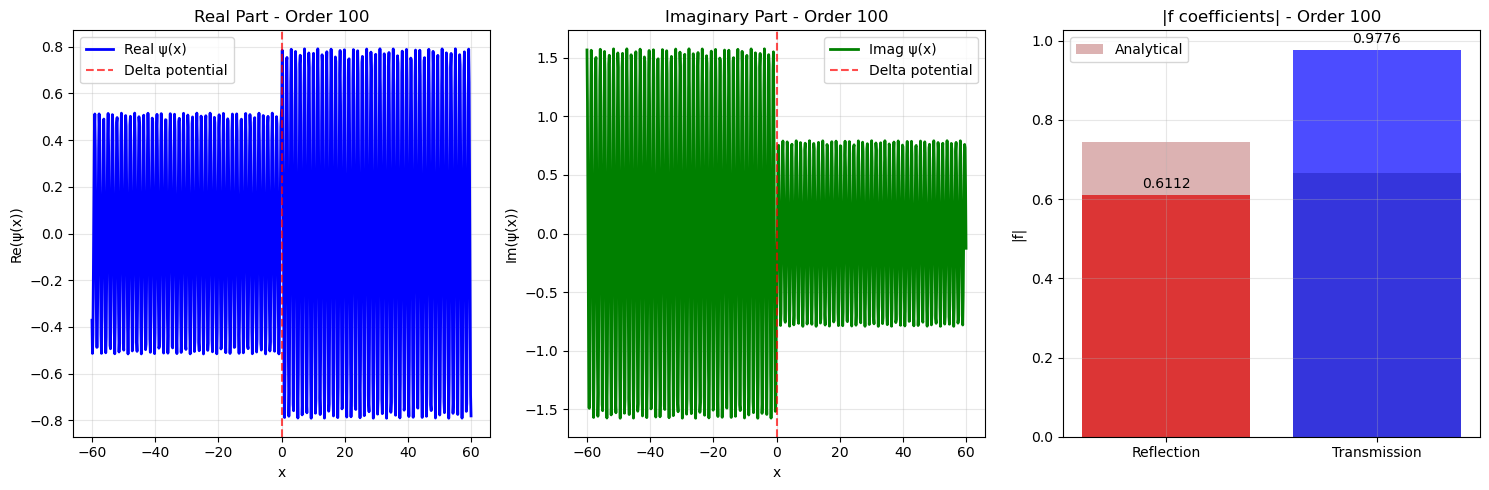

In [9]:
# Generate plots for selected orders
selected_orders = [5,10,15,20,25,30,35,40,45,50,60,70,80,90,100]# [0, 1, 2, 5, order_max]
for order in selected_orders:
    if order <= order_max:
        plot_order_results(order)


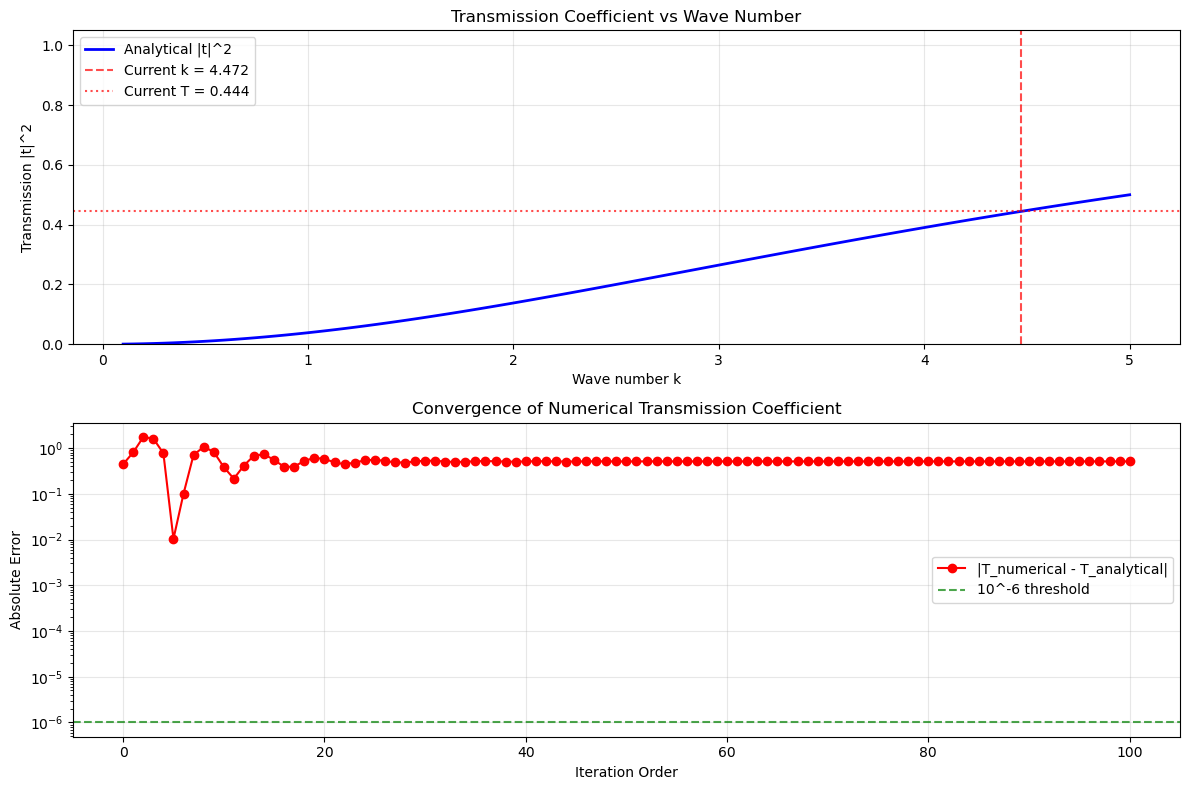

Final numerical transmission: 0.95568510
Analytical transmission:      0.44444444
Absolute error:              5.11e-01


In [10]:
# Plot transmission coefficient vs k
k_range = np.linspace(0.1, 5.0, 100)
T_analytical = transmission_vs_k(k_range, V0, mass, hbar)

plt.figure(figsize=(12, 8))

# Analytical curve
plt.subplot(2, 1, 1)
plt.plot(k_range, T_analytical, 'b-', linewidth=2, label='Analytical |t|^2')
plt.axvline(x=k, color='r', linestyle='--', alpha=0.7, 
           label=f'Current k = {k:.3f}')
plt.axhline(y=np.abs(t_exact)**2, color='r', linestyle=':', alpha=0.7,
           label=f'Current T = {np.abs(t_exact)**2:.3f}')

plt.title('Transmission Coefficient vs Wave Number')
plt.xlabel('Wave number k')
plt.ylabel('Transmission |t|^2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Convergence plot
plt.subplot(2, 1, 2)
orders = range(order_max + 1)
T_numerical_orders = [np.abs(f_orders[i][1])**2 for i in orders]

plt.semilogy(orders, np.abs(np.array(T_numerical_orders) - np.abs(t_exact)**2), 
            'ro-', label='|T_numerical - T_analytical|')
plt.axhline(y=1e-6, color='g', linestyle='--', alpha=0.7, label='10^-6 threshold')

plt.title('Convergence of Numerical Transmission Coefficient')
plt.xlabel('Iteration Order')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final numerical transmission: {T_numerical_orders[-1]:.8f}")
print(f"Analytical transmission:      {np.abs(t_exact)**2:.8f}")
print(f"Absolute error:              {abs(T_numerical_orders[-1] - np.abs(t_exact)**2):.2e}") 
